# Python实现多元线性回归
[参考](https://blog.csdn.net/weixin_40014576/article/details/79918819)

## 线性回归介绍
线性回归是利用数理统计中回归分析，来确定两种或两种以上变量间相互依赖的定量关系的一种统计分析方法，运用十分广泛。其表达形式为`y = (w.T)x+e`，e为误差服从均值为0的正态分布。回归分析中，只包括一个自变量和一个因变量，且二者的关系可用一条直线近似表示，这种回归分析称为一元线性回归分析。如果回归分析中包括两个或两个以上的自变量，且因变量和自变量之间是线性关系，则称为多元线性回归分析。

线性回归属于回归问题。对于回归问题，解决流程为：   
给定数据集中每个样本及其正确答案，选择一个模型函数h（hypothesis，假设），并为h找到适应数据的（未必是全局）最优解，即找出最优解下的h的参数。这里给定的数据集取名叫训练集（Training Set）。不能所有数据都拿来训练，要留一部分验证模型好不好使，这点以后说。先列举几个几个典型的模型：
- 最基本的单变量线性回归：   
    形如`h(x)=theta0+theta1*x1`
- 多变量线性回归：   
    形如`h(x)=theta0+theta1*x1+theta2*x2+theta3*x3`
- 多项式回归（Polynomial Regression）：   
    形如`h(x)=theta0+theta1*x1+theta2*(x2^2)+theta3*(x3^3)`   
    或者`h(x)=ttheta0+theta1*x1+theta2*sqr(x2)`   
    但是可以令`x2=x2^2`，`x3=x3^3`，于是又将其转化为了线性回归模型。虽然不能说多项式回归问题属于线性回归问题，但是一般我们就是这么做的。
- 所以最终通用表达式就是：  
    `h(x) = (theta.T)*X = theta0+theta1*x1+theta2*x2+...+thetan*xn`

## 数据导入与清洗
对于数据导入来说，可以利用pandas内的read_csv的函数来对数据进行导入操作，在进行多元线性回归之间通过简单线性回归来展现线性回归的特性和结果之后再延伸至多元线性回归。

在进行数据导入之间需要导入进行线性回归的包：

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

我们利用pandas和numpy对数据进行操作，使用matplotlib进行图像化，使用sklearn进行数据集训练与模型导入。

## 简单线性回归

### 数据集创建
对于学生来说，所学习的时间和考试的成绩挂钩，所学习的时间与考试的成绩也是呈线性相关。创建一个数据集来描述学生学习时间与成绩的关系并且做简单的线性回归。

In [2]:
#创建数据集
examDict  = {'学习时间':[0.50,0.75,1.00,1.25,1.50,1.75,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,4.00,4.25,4.50,4.75,5.00,5.50],
             '分数':[10,22,13,43,20,22,33,50,62,48,55,75,62,73,81,76,64,82,90,93]}
#转换为DataFrame的数据格式
examDf = pd.DataFrame(examDict)

In [3]:
examDf

,分数,学习时间
0,10,0.50
1,22,0.75
2,13,1.00
3,43,1.25
4,20,1.50
5,22,1.75
6,33,1.75
7,50,2.00
8,62,2.25
9,48,2.50


从上面的数据可以看到数据的特征值与其标签，学生所学习的时间就是所需要的特征值，而成绩就是通过特征值所反应的标签。在这个案例中要对数据进行观测来反应学习时间与成绩的情况，将利用散点图来实现简单的观测。

### 数据集散点图

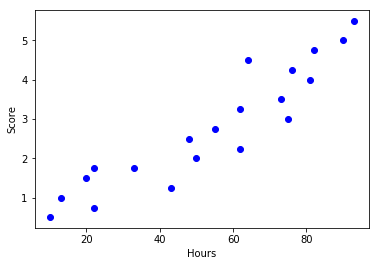

In [4]:
#绘制散点图
plt.scatter(examDf['分数'],examDf['学习时间'],color = 'b',label = "Exam Data")
#添加图的标签（x轴、y轴）
plt.xlabel("Hours")
plt.ylabel("Score")
#显示图像
plt.show()

从上图可以看到对于分数和时间来说存在相应的线性关系，且俩数据间相关性较强。在此可以通过相关性来衡量两个变量因素的相关密切程度。

### 相关系数

**相关系数是用以反映变量之间相关关系密切程度的统计指标。**

`r(相关系数) = x和y的协方差/(x的标准差*y的标准差) == cov（x,y）/σx*σy（即person系数）`

对于相关性强度来说的化有以下的关系：
- 0~0.3 弱相关
- 0.3~0.6  中等程度相关
- 0.6~1  强相关

In [5]:
rDf = examDf.corr()
print(rDf)

            分数      学习时间
分数    1.000000  0.923985
学习时间  0.923985  1.000000


pandas中的数学统计函数`DataFrame.corr()`可以反应数据间的相关性关系，可从表值中反应出学习时间与分数之间的相关性为强相关（0.6~1）。

### 最小二乘法

对于简单线性回归来说，简单回归方程为： `y = a + b*x`(模型建立最佳拟合线)最佳拟合线也是需要通过最小二乘法来实现其作用。对于OLS即最小二乘法我们需要知道的一个关系为**点误差**，`点误差 = 实际值 - 预测值`，而**误差平方和（Sum of square error）**`SSE = Σ（实际值-预测值）^2`，最小二乘法就是基于SSE实现，最小二乘法 ： 使得误差平方和最小（最佳拟合）。

### 训练集、测试集划分
解释完简单线性回归后进行对训练集和测试集的创建，将会使用train_test_split函数来创建（train_test_split是存在与sklearn中的函数）

In [6]:
exam_X = examDf['学习时间']
exam_Y = examDf['分数']
#将原数据集拆分训练集和测试集
X_train,X_test,Y_train,Y_test = train_test_split(exam_X,exam_Y,train_size = 0.8,test_size = 0.2)
#X_train为训练数据标签,X_test为测试数据标签,exam_X为样本特征,exam_y为样本标签，train_size 训练数据占比
print("原始数据特征:",exam_X.shape,",训练数据特征:",X_train.shape,",测试数据特征:",X_test.shape)
print("原始数据标签:",exam_Y.shape,",训练数据标签:",Y_train.shape,",测试数据标签:",Y_test.shape)

原始数据特征: (20,) ,训练数据特征: (16,) ,测试数据特征: (4,)
原始数据标签: (20,) ,训练数据标签: (16,) ,测试数据标签: (4,)


下面是可视化。

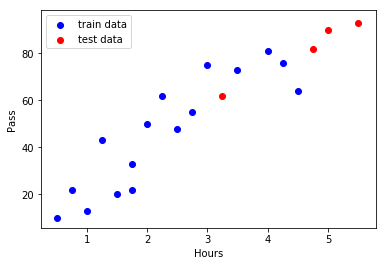

In [7]:
#散点图
plt.scatter(X_train, Y_train, color="blue", label="train data")
plt.scatter(X_test, Y_test, color="red", label="test data")
 
#添加图标标签
plt.legend(loc=2)
plt.xlabel("Hours")
plt.ylabel("Pass")
#显示图像
plt.show()

tips:由于训练集随机分配的原因每一次运行的结果（点的分布情况，训练集内的情况，测试集内的情况）不都相同。

### 模型训练
在创建数据集之后我们需要将训练集放入skleran中的线性回归模型`LinearRegression()`进行训练，使用函数种的`.fit`函数进行模型的训练操作。

In [8]:
model = LinearRegression()

#对于模型错误我们需要把我们的训练集进行reshape操作来达到函数所需要的要求
 
#reshape如果行数=-1的话可以使我们的数组所改的列数自动按照数组的大小形成新的数组
#因为model需要二维的数组来进行拟合但是这里只有一个特征所以需要reshape来转换为二维数组
X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)

model.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的`intercept_`与`coef_`来得到。

In [9]:
a = model.intercept_ #截距
b = model.coef_ #回归系数
print("最佳拟合线：截距",a,",回归系数：",b)

最佳拟合线：截距 6.837689362410515 ,回归系数： [17.11669719]


由上述的最佳拟合线的截距和回归系数可以算出其线性回归线方程：  
`y = 7.56 + 16.28*x`

### 模型评价
接下来需要对模型进行预测和对模型进行评价，在进行评价之间将会引入一个决定系数R平方的概念。

决定系数R平方常用于评估模型的精确度。

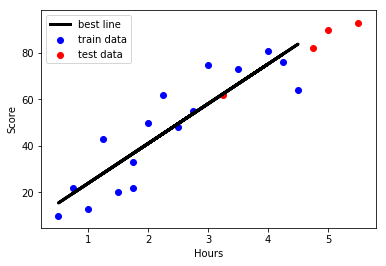

In [10]:
#训练数据的预测值
y_train_pred = model.predict(X_train)
#绘制最佳拟合线：标签用的是训练数据的预测值y_train_pred
plt.plot(X_train, y_train_pred, color='black', linewidth=3, label="best line")

#测试数据散点图
plt.scatter(X_train, Y_train, color="blue", label="train data")
plt.scatter(X_test, Y_test, color='red', label="test data")

#添加图标标签
plt.legend(loc=2)
plt.xlabel("Hours")
plt.ylabel("Score")
#显示图像
plt.show()

In [11]:
score = model.score(X_test,Y_test)
print(score)

0.8161998892697531


## 多元线性回归
在间单线性回归的例子中可以得到与线性回归相关的分析流程，接下来对多元线性回归进行分析。

### 数据导入
对于多元线性回归前面已经提到，形如`h(x)=theta0+theta1*x1+theta2*x2+theta3*x3`

下面我们从[http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv](http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv) 来下载数据集Advertising.csv，其数据描述了一个产品的销量与广告媒体的投入之间影响。

In [13]:
#通过read_csv来读取我们的目的数据集
adv_data = pd.read_csv("Advertising.csv")
#清洗不需要的数据
new_adv_data = adv_data.iloc[:,1:]
#得到我们所需要的数据集且查看其前几列以及数据形状
print('head:',new_adv_data.head(),'\nShape:',new_adv_data.shape)

head:       TV  radio  newspaper  sales
0  230.1   37.8       69.2   22.1
1   44.5   39.3       45.1   10.4
2   17.2   45.9       69.3    9.3
3  151.5   41.3       58.5   18.5
4  180.8   10.8       58.4   12.9 
Shape: (200, 4)


对于上述的数据可以得到数据中

标签值（sales）：
- Sales：对应产品的销量

特征值（TV，Radio，Newspaper）：
- TV：对于一个给定市场中单一产品，用于电视上的广告费用（以千为单位）
- Radio：在广播媒体上投资的广告费用
- Newspaper：用于报纸媒体的广告费用

在这个案例中，通过不同的广告投入，预测产品销量。因为响应变量是一个连续的值，所以这个问题是一个回归问题。数据集一共有200个观测值，每一组观测对应一个市场的情况。接下里对数据进行描述性统计，以及寻找缺失值（缺失值对模型的影响较大，如发现缺失值应替换或删除）,且利用箱图来从可视化方面来查看数据集，在描述统计之后对数据进行相关性分析，以此来查找数据中特征值与标签值之间的关系。

### 数据描述

In [15]:
#数据描述
new_adv_data.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


### 缺失值检验

In [16]:
#缺失值检验
new_adv_data[new_adv_data.isnull()==True].count()

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

### 箱形图

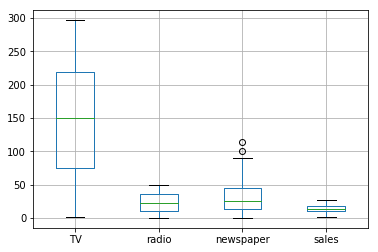

In [17]:
new_adv_data.boxplot()
plt.show()

### 相关系数

In [18]:
##相关系数矩阵 r(相关系数) = x和y的协方差/(x的标准差*y的标准差) == cov（x,y）/σx*σy
#相关系数0~0.3弱相关0.3~0.6中等程度相关0.6~1强相关
new_adv_data.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.054809,0.056648,0.782224
radio,0.054809,1.000000,0.354104,0.576223
newspaper,0.056648,0.354104,1.000000,0.228299
sales,0.782224,0.576223,0.228299,1.000000


可以从corr表中看出，TV特征和销量是有比较强的线性关系的，而Radio和Sales线性关系弱一些但是也是属于强相关的，Newspaper和Sales线性关系更弱。接下来建立散点图来查看数据里的数据分析情况以及对相对应的线性情况，将使用seaborn的pairplot来绘画3种不同的因素对标签值的影响。

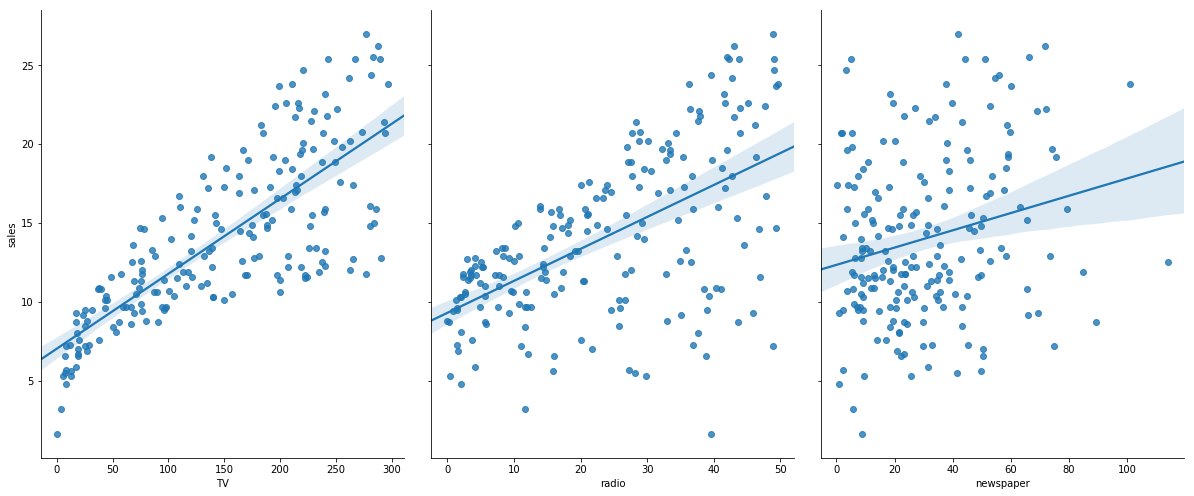

In [21]:
# 通过加入一个参数kind='reg'，seaborn可以添加一条最佳拟合直线和95%的置信带。
sns.pairplot(new_adv_data, x_vars=['TV','radio','newspaper'], y_vars='sales', size=7, aspect=0.8,kind = 'reg')
plt.show()

如上图所示，可以了解到不同的因素对销量的预测线（置信度= 95 %），也可以大致看出不同特征对于标签值的影响与相关关系。

### 建立模型
在了解了数据的各种情况后需要对数据集建立模型，在建立模型的第一步我们将建立训练集与测试集，同样的我们将会使用train_test_split函数来创建。

In [22]:
X_train,X_test,Y_train,Y_test = train_test_split(new_adv_data.iloc[:,:3],new_adv_data.sales,train_size = 0.8,test_size = 0.2)
 
print("原始数据特征:",new_adv_data.iloc[:,:3].shape,",训练数据特征:",X_train.shape,",测试数据特征:",X_test.shape)
print("原始数据标签:",new_adv_data.sales.shape,",训练数据标签:",Y_train.shape,",测试数据标签:",Y_test.shape)

原始数据特征: (200, 3) ,训练数据特征: (160, 3) ,测试数据特征: (40, 3)
原始数据标签: (200,) ,训练数据标签: (160,) ,测试数据标签: (40,)


建立初步的数据集模型之后将训练集中的特征值与标签值放入LinearRegression()模型中且使用fit函数进行训练,在模型训练完成之后会得到所对应的方程式（线性回归方程式）需要利用函数中的intercept_与coef_。

In [23]:
model = LinearRegression()
model.fit(X_train,Y_train)

a  = model.intercept_ #截距 
b = model.coef_ #回归系数
print("最佳拟合线:截距",a,",回归系数：",b)

最佳拟合线:截距 2.7283555357741935 ,回归系数： [ 0.04665892  0.19082797 -0.00099623]


即所得的多元线性回归模型的函数为 ：   
`y = 2.79 + 0.04 * TV + 0.187 * Radio - 0.002 * Newspaper`。  
对于给定了Radio和Newspaper的广告投入，如果在TV广告上每多投入1个单位，对应销量将增加0.04711个单位。就是加入其它两个媒体投入固定，在TV广告上每增加1000美元（因为单位是1000美元），销量将增加47.11（因为单位是1000）。

但是大家注意这里的newspaper的系数居然是负数，所以我们可以考虑不使用newspaper这个特征。

### 模型评估
接下来对数据集进行预测与模型测评。同样使用predict与score函数来获取所需要的预测值与得分。

**R方检测---决定系数R平方**
- y误差平方和 = Σ(y实际值 - y预测值)^2
- y的总波动 = Σ(y实际值 - y平均值)^2
- 有多少百分比的y波动没有被回归拟合线所描述 = SSE/总波动
- 有多少百分比的y波动被回归线描述 = 1 - SSE/总波动 = 决定系数R平方

In [24]:
score = model.score(X_test,Y_test) 
print(score)

0.9028750733729708


In [25]:
#对线性回归进行预测
Y_pred = model.predict(X_test)
print(Y_pred)

[ 5.88658387 19.04199354 19.52640033 17.70822778 10.71716318  5.2030417
 24.26646035 12.76256323  9.82255698 18.52225153 21.3759422   7.45340113
  4.28180262 19.73124396 20.7434211  20.46565901  8.02140753 21.32827151
 15.59515058  8.76729192 18.44116227 10.52302626 13.16705012 15.18864077
  9.9417295  15.2734619  12.1230943  10.46509366 11.64698928 13.9265036
 15.06236293  6.66457005 12.6079046  18.00988685 17.10350626  9.24127309
 11.36598772 18.937225    6.43101507  6.89520345]


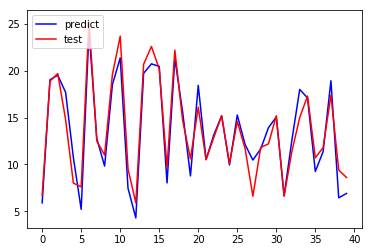

In [28]:
plt.plot(range(len(Y_pred)),Y_pred,'b',label="predict")
plt.plot(range(len(Y_test)),Y_test,'r',label="test")
#显示图像
#添加图标标签
plt.legend(loc=2)
plt.show()